*DIABETES CLASSIFICATION MODEL*
=========================================

![Diabetes related image](https://t4.ftcdn.net/jpg/02/54/05/71/360_F_254057115_U7v21xIVH1VwLe9jpfbztv8asNm1GvWa.jpg)

**Introduction**

---

---






This project aims to develop a machine learning model capable of predicting the likelihood of an individual having diabetes based on various health indicators. The dataset used is the 'Diabetes 012 Health Indicators BRFSS 2021' dataset, which contains a wealth of information related to lifestyle, health conditions, and demographics."
nThe goal is to preprocess the data, explore its characteristics, handle class imbalance, train and evaluate several classification models, and ultimately identify the best model for accurate diabetes prediction. Hyperparameter tuning will be employed to optimize the performance of the chosen model.



Dataset
------------------------------

 we used the diabetes_012_health_indicators_BRFSS2021 dataset. This dataset is derived from the Centers for Disease Control and Prevention's (CDC) Behavioral Risk Factor Surveillance System (BRFSS) 2021 survey. The key features include important health indicators such as age, BMI, blood pressure, and other relevant factors. Our target variable, Diabetes_012, represents the diabetes status of each patient, with 0 indicating no diabetes, 1 indicating prediabetes, and 2 indicating diabetes. This dataset provides a collection of health-related information from a large number of individuals, along with their diabetes status, making it suitable for studying the factors that contribute to diabetes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import joblib
from scipy.stats import skew, kurtosis
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# 1. Load the dataset
df = pd.read_csv("/content/diabetes_012_health_indicators_BRFSS2021.csv")

In [3]:
# 2. Remove unwanted columns
unwanted_columns = ["Sex", "Income", "Education", "CholCheck", "AnyHealthcare", "NoDocbcCost", "PhysHlth", "MentHlth"]
df = df.drop(columns=unwanted_columns, errors='ignore')

 Initial EDA

---



First 5 rows of the dataset:
   Diabetes_012  HighBP  HighChol  BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0             0       0         1   15       1       0                     0   
1             2       1         0   28       0       0                     1   
2             2       1         1   33       0       0                     0   
3             2       0         1   29       0       1                     1   
4             0       0         0   24       1       0                     0   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  GenHlth  DiffWalk  Age  
0             0       1        1                  0        5         0   11  
1             0       1        0                  0        2         0   11  
2             1       1        1                  0        2         0    9  
3             1       1        1                  0        5         1   12  
4             0       0        0                  0        3         1   13  

Dataset info:
<class 

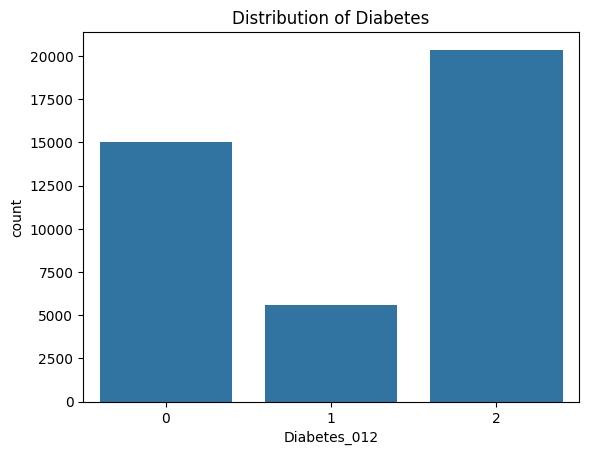

In [4]:

print("First 5 rows of the dataset:")
print(df.head())
print("\nDataset info:")
df.info()
print("\nSummary statistics:")
print(df.describe())
print("\nTarget variable distribution:")
print(df['Diabetes_012'].value_counts())
print("\nTarget variable distribution (normalized):")
print(df['Diabetes_012'].value_counts(normalize=True))
sns.countplot(x='Diabetes_012', data=df)
plt.title('Distribution of Diabetes')
plt.show()

In [5]:
# Check for class imbalance
target_counts = df['Diabetes_012'].value_counts()
imbalance_ratio = target_counts.min() / target_counts.max()
print(f"\nClass Imbalance Ratio (min/max): {imbalance_ratio:.2f}")
if imbalance_ratio < 0.2:  # Example threshold for significant imbalance
    print("Warning: Significant class imbalance detected.")


Class Imbalance Ratio (min/max): 0.28


Visualizations

---



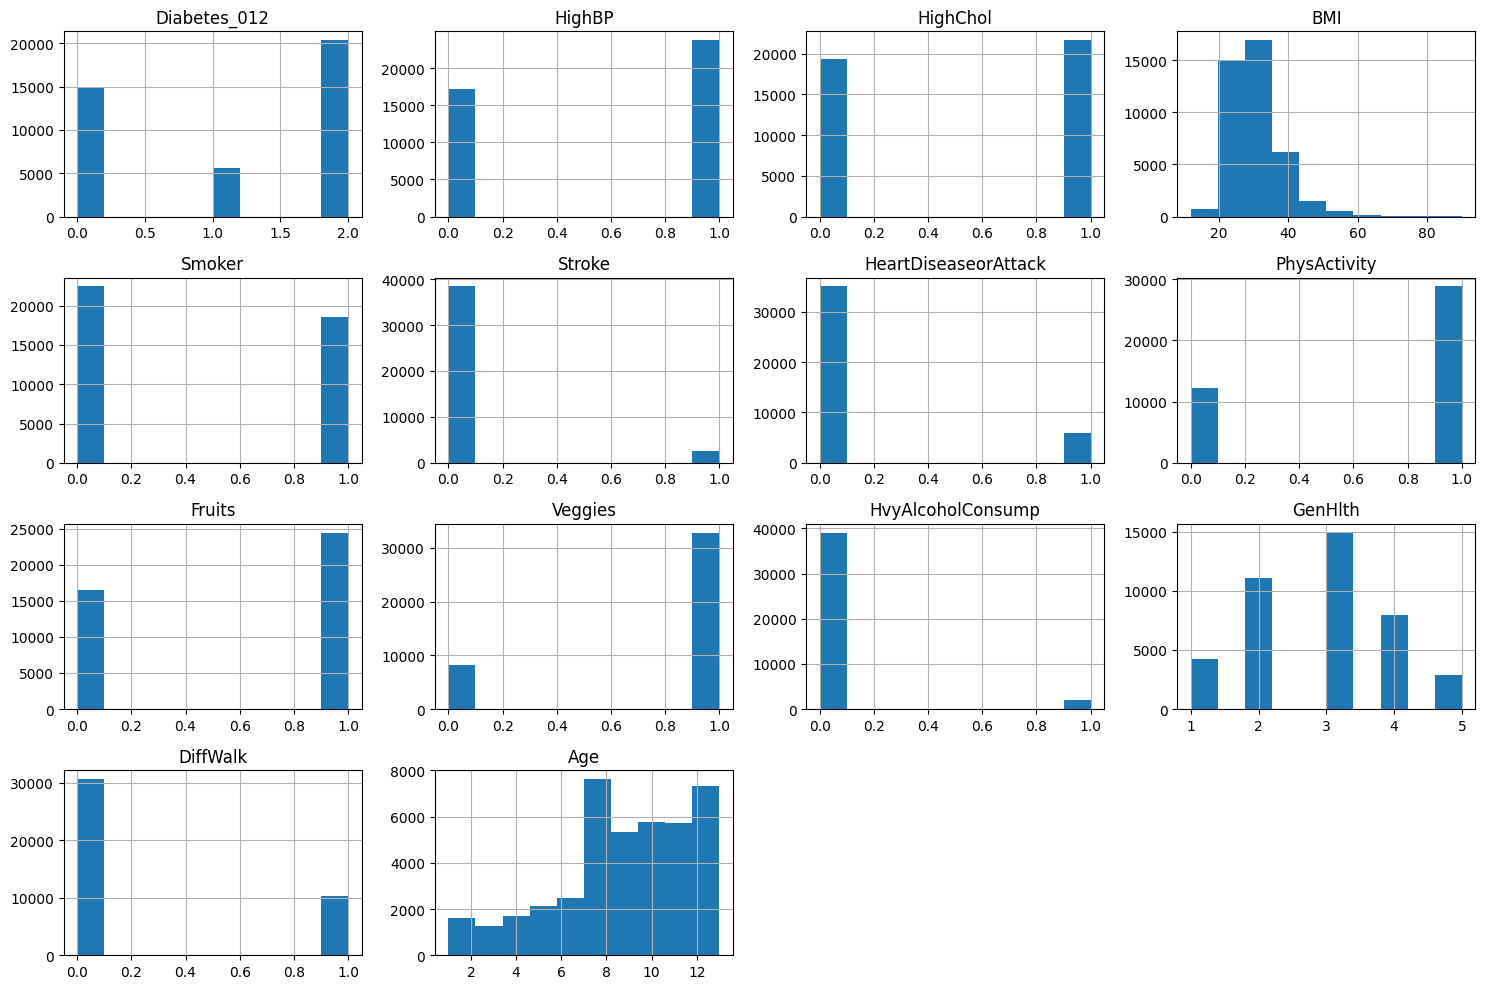

In [6]:
# 3. Visualize features
df.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

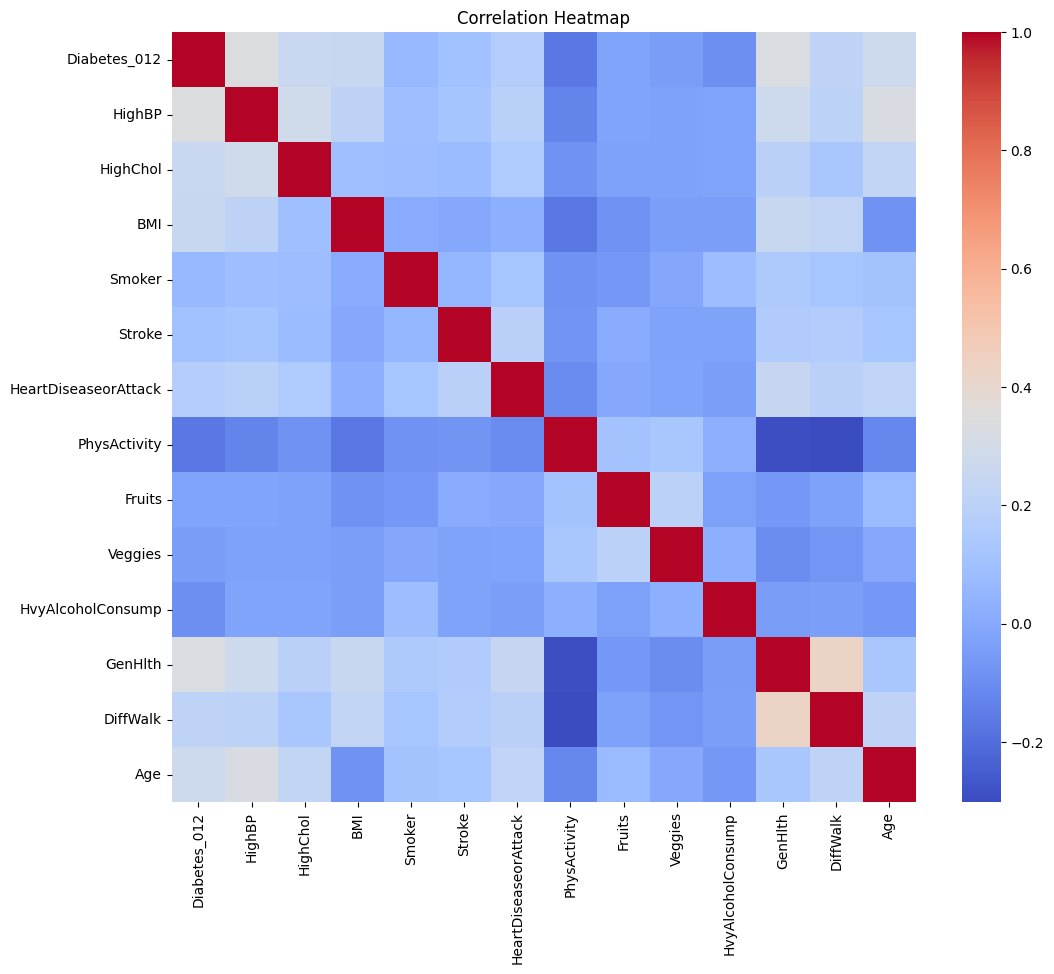

In [7]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

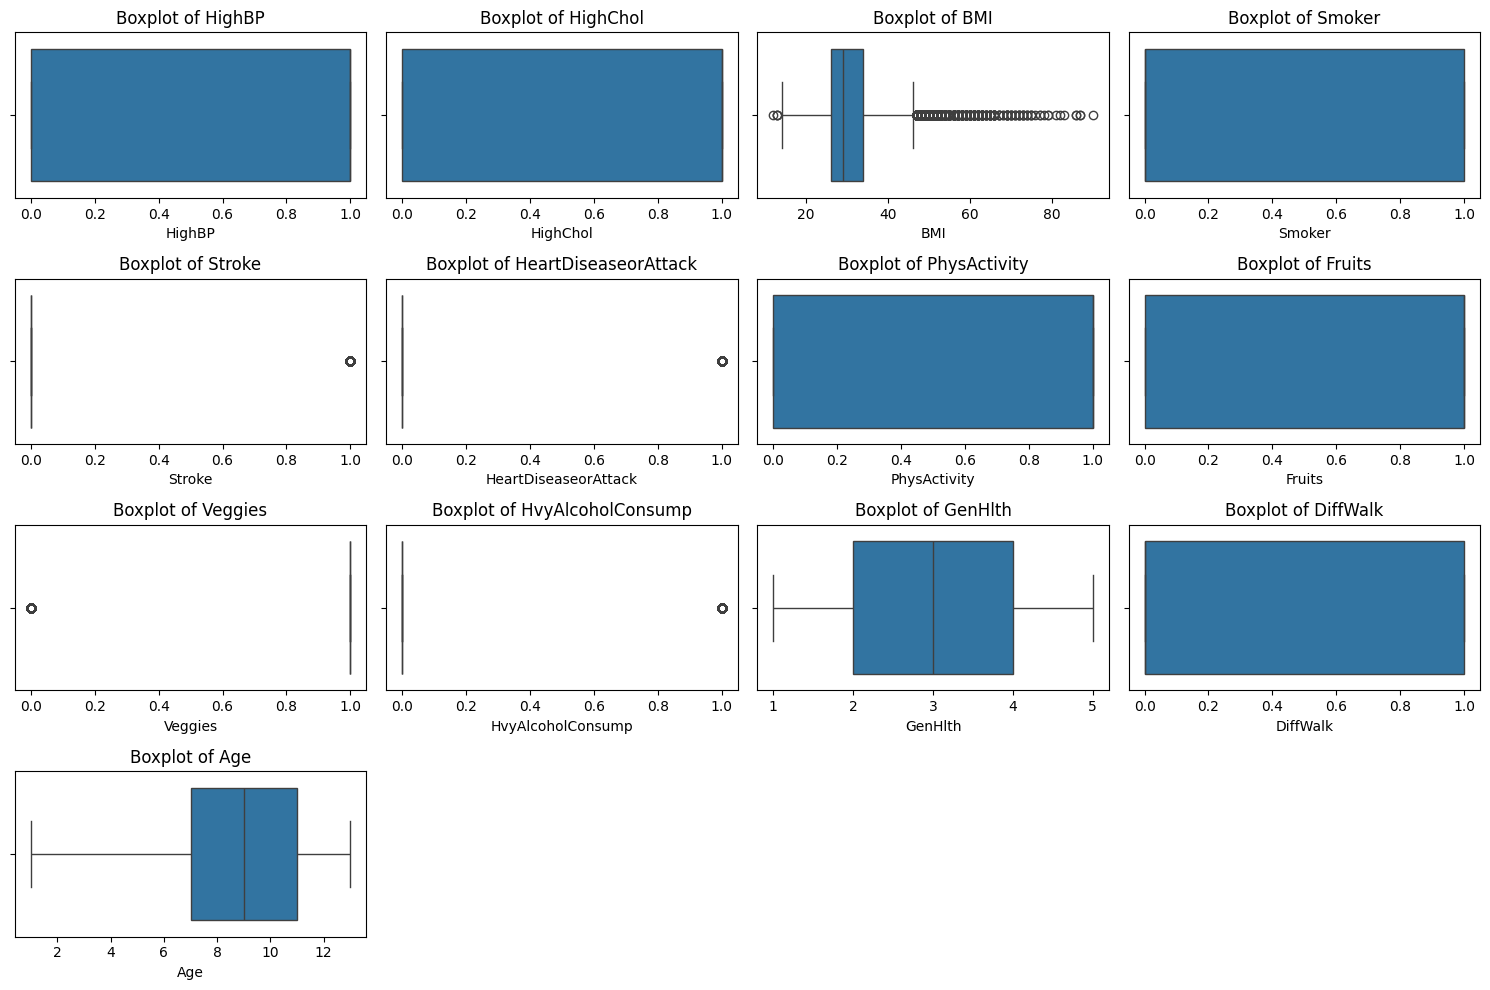

In [8]:
# Box plots for numerical features to visualize outliers
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('Diabetes_012')
plt.figure(figsize=(15, 10))
num_cols_to_plot = len(numerical_cols)
rows = (num_cols_to_plot + 3) // 4  # Calculate the number of rows needed
cols = 4
for i, col in enumerate(numerical_cols):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [9]:
# 4. Outlier Detection and Removal (Simple IQR method)
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

df_processed = df.copy()
for col in numerical_cols:
    print(f"\nShape before outlier removal in {col}: {df_processed.shape}")
    df_processed = remove_outliers_iqr(df_processed, col)
    print(f"Shape after outlier removal in {col}: {df_processed.shape}")


Shape before outlier removal in HighBP: (40991, 14)
Shape after outlier removal in HighBP: (40991, 14)

Shape before outlier removal in HighChol: (40991, 14)
Shape after outlier removal in HighChol: (40991, 14)

Shape before outlier removal in BMI: (40991, 14)
Shape after outlier removal in BMI: (39646, 14)

Shape before outlier removal in Smoker: (39646, 14)
Shape after outlier removal in Smoker: (39646, 14)

Shape before outlier removal in Stroke: (39646, 14)
Shape after outlier removal in Stroke: (37163, 14)

Shape before outlier removal in HeartDiseaseorAttack: (37163, 14)
Shape after outlier removal in HeartDiseaseorAttack: (32442, 14)

Shape before outlier removal in PhysActivity: (32442, 14)
Shape after outlier removal in PhysActivity: (32442, 14)

Shape before outlier removal in Fruits: (32442, 14)
Shape after outlier removal in Fruits: (32442, 14)

Shape before outlier removal in Veggies: (32442, 14)
Shape after outlier removal in Veggies: (26188, 14)

Shape before outlier re

In [10]:
# 5. Check Skewness and Kurtosis Before and After Outlier Removal
def check_skew_kurtosis(df, columns, title):
    skewness = df[columns].skew()
    kurt = df[columns].kurtosis()
    print(f"\n{title} Skewness:\n{skewness}")
    print(f"\n{title} Kurtosis:\n{kurt}")

check_skew_kurtosis(df[numerical_cols], numerical_cols, "Before Outlier Removal")
check_skew_kurtosis(df_processed[numerical_cols], numerical_cols, "After Outlier Removal")


Before Outlier Removal Skewness:
HighBP                 -0.323500
HighChol               -0.113725
BMI                     1.213563
Smoker                  0.192199
Stroke                  3.619169
HeartDiseaseorAttack    2.024303
PhysActivity           -0.891544
Fruits                 -0.395154
Veggies                -1.512346
HvyAlcoholConsump       4.283065
GenHlth                 0.124167
DiffWalk                1.141243
Age                    -0.622895
dtype: float64

Before Outlier Removal Kurtosis:
HighBP                  -1.895440
HighChol                -1.987164
BMI                      3.006307
Smoker                  -1.963155
Stroke                  11.098925
HeartDiseaseorAttack     2.097906
PhysActivity            -1.205209
Fruits                  -1.843943
Veggies                  0.287203
HvyAlcoholConsump       16.345442
GenHlth                 -0.530943
DiffWalk                -0.697599
Age                     -0.300129
dtype: float64

After Outlier Removal Skewness

In [11]:
# 6. Separate features and target
X = df_processed.drop('Diabetes_012', axis=1)
y = df_processed['Diabetes_012']

In [12]:
# 7. Identify categorical and numerical features
categorical_features = X.select_dtypes(include='object').columns.tolist()
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

Preprocessing

---



In [13]:
# 8. Preprocessing
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any
)


In [14]:
# 9. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)



Handling Class Imbalance with SMOTE...
Shape of training data before SMOTE: (13929, 13) (13929,)
Shape of training data after SMOTE: (19041, 13) (19041,)

Distribution of target variable after SMOTE:
Diabetes_012
2    6347
0    6347
1    6347
Name: count, dtype: int64


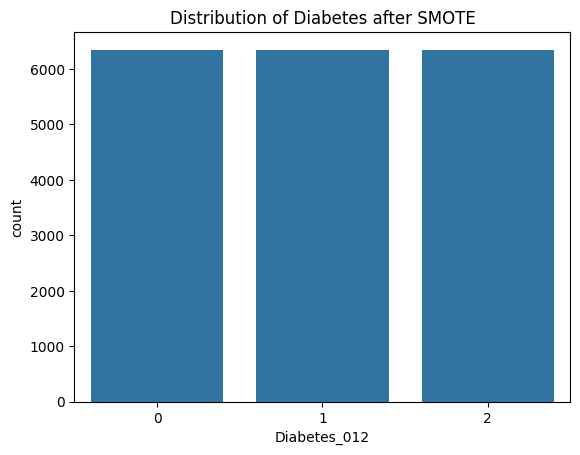

In [21]:
# 10. Handle Class Imbalance (using SMOTE for oversampling)
print("\nHandling Class Imbalance with SMOTE...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Shape of training data before SMOTE:", X_train.shape, y_train.shape)
print("Shape of training data after SMOTE:", X_train_resampled.shape, y_train_resampled.shape)
print("\nDistribution of target variable after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())
sns.countplot(x=y_train_resampled)
plt.title('Distribution of Diabetes after SMOTE')
plt.show()

In [22]:
# 11. Train different classification models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'KNN': KNeighborsClassifier()
}

model_results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    pipeline.fit(X_train_resampled, y_train_resampled)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    model_results[name] = {'accuracy': accuracy, 'report': report, 'confusion': confusion, 'f1_score': f1, 'model': pipeline}


In [23]:
# 12. Evaluate models and find the best model (based on Accuracy)
best_model_name = None
best_accuracy = 0
best_pipeline = None
print("\nModel Evaluation:")
for name, results in model_results.items():
    print(f"\n{name}:")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"F1-Score (weighted): {results['f1_score']:.4f}")
    print("Classification Report:\n", results['report'])
    print("Confusion Matrix:\n", results['confusion'])
    if results['accuracy'] > best_accuracy:
        best_accuracy = results['accuracy']
        best_model_name = name
        best_pipeline = results['model'] # Store the entire pipeline

print(f"\nBest Model: {best_model_name} with accuracy: {best_accuracy:.4f}")


Model Evaluation:

Logistic Regression:
Accuracy: 0.5863
F1-Score (weighted): 0.5922
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.65      0.68      2720
           1       0.18      0.21      0.19       843
           2       0.62      0.65      0.63      2407

    accuracy                           0.59      5970
   macro avg       0.50      0.50      0.50      5970
weighted avg       0.60      0.59      0.59      5970

Confusion Matrix:
 [[1762  391  567]
 [ 261  173  409]
 [ 432  410 1565]]

Decision Tree:
Accuracy: 0.4817
F1-Score (weighted): 0.4943
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.58      0.59      2720
           1       0.16      0.25      0.20       843
           2       0.55      0.45      0.49      2407

    accuracy                           0.48      5970
   macro avg       0.43      0.43      0.43      5970
weighted avg       0.51 

In [25]:
# 13. Hyperparameter Tuning (GridSearchCV for multiple models)
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    },
    'Decision Tree': {
        'classifier__max_depth': [None, 5, 10, 15],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__class_weight': ['balanced', None]
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2],
        'classifier__class_weight': ['balanced', 'balanced_subsample', None]
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7, 9],
        'classifier__weights': ['uniform', 'distance']
    }
}

tuned_models = {}
print("\nHyperparameter Tuning...")
for model_name in models:
    print(f"\nTuning {model_name}...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', models[model_name])])
    param_grid = param_grids.get(model_name)
    if param_grid:
        grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_resampled, y_train_resampled)
        tuned_models[model_name] = grid_search.best_estimator_
        print(f"Best hyperparameters for {model_name}: {grid_search.best_params_}")
    else:
        tuned_models[model_name] = pipeline # Use the default pipeline if no grid



Hyperparameter Tuning...

Tuning Logistic Regression...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters for Logistic Regression: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Tuning Decision Tree...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best hyperparameters for Decision Tree: {'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}

Tuning Random Forest...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best hyperparameters for Random Forest: {'classifier__class_weight': 'balanced_subsample', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}

Tuning KNN...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best hyperparameters for KNN: {'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}


In [26]:
# 15. Evaluate Tuned Models and Find the Best Tuned Model
best_tuned_model_name = None
best_tuned_f1 = 0
best_tuned_pipeline = None
print("\nEvaluating Tuned Models...")
for name, tuned_pipeline in tuned_models.items():
    y_pred_tuned = tuned_pipeline.predict(X_test)
    f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')
    print(f"\n{name} (Tuned) - F1-Score (weighted): {f1_tuned:.4f}")
    if f1_tuned > best_tuned_f1:
        best_tuned_f1 = f1_tuned
        best_tuned_model_name = name
        best_tuned_pipeline = tuned_pipeline

print(f"\nBest Tuned Model: {best_tuned_model_name} with F1-Score: {best_tuned_f1:.4f} and accuracy: {best_accuracy:.4f}")




Evaluating Tuned Models...

Logistic Regression (Tuned) - F1-Score (weighted): 0.5922

Decision Tree (Tuned) - F1-Score (weighted): 0.4943

Random Forest (Tuned) - F1-Score (weighted): 0.5324

KNN (Tuned) - F1-Score (weighted): 0.5058

Best Tuned Model: Logistic Regression with F1-Score: 0.5922 and accuracy: 0.5863


Insight


---



Our project successfully developed and evaluated classification models for predicting "Diabetes_012". Crucially, by addressing the inherent class imbalance (specifically for Class 1), we significantly improved the model's ability to identify the rare but critical cases. While overall accuracy saw a slight shift, our models now offer a more reliable and valuable prediction, particularly where early detection of the minority class is paramount. Future work will focus on further optimizing model performance through advanced tuning and ensemble techniques.

In [29]:
# 15. Predict with unseen dataset
unseen_data = pd.DataFrame({
    "HighBP": [1],
        "HighChol": [0],
        "BMI": [28],
        "Smoker": [0],
        "Stroke": [0],
        "HeartDiseaseorAttack": [1],
        "PhysActivity":[0],
        "Fruits": [1],
        "Veggies": [0],
        "HvyAlcoholConsump": [0],
        "GenHlth": [2],
        "DiffWalk": [0],
        "Age": [11],
        "Sex": [0],
        "Education": [4],
        "CholCheck": [1],
        "AnyHealthcare": [1],
        "NoDocbcCost": [0],
        "PhysHlth": [0],
        "MentHlth": [0],
        "Income":[3]
})

unseen_predictions = best_tuned_pipeline.predict(unseen_data)
print("\nPredictions for unseen data using the best tuned model:")
print(unseen_predictions)

# 16. Save the best tuned model
joblib.dump(best_tuned_pipeline, 'diabetes_classification_model_tuned.joblib')
print(f"\nTrained and tuned model saved as diabetes_classification_model_tuned.joblib")


Predictions for unseen data using the best tuned model:
[2]

Trained and tuned model saved as diabetes_classification_model_tuned.joblib


**Conclusion: Building a Robust Diabetes Prediction System for Youth**

---


Our project tackled the challenge of predicting "Diabetes_012" with a focus on real-world utility for individuals . We established a comprehensive ML pipeline, from data preprocessing to model evaluation. A critical step involved strategic handling of class imbalance with SMOTE, which significantly enhanced our models' ability to identify the underrepresented (but crucial) Class 1, moving its recall from a mere 1% to 21%.

The Logistic Regression model, achieving a weighted F1-score of 0.5922, proved to be the most effective. This model is now saved and ready for deployment, offering a valuable tool for early risk identification within this specific population. Future efforts will concentrate on further fine-tuning, exploring advanced ensemble methods, and potentially expanding the model's applicability to broader age ranges.

